In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import jax.numpy as np
from jax import device_get, random, vmap
from jax.config import config; config.update('jax_platform_name', 'cpu')

import numpyro.distributions as dist
from numpyro.distributions.util import softmax
from numpyro.hmc_util import initialize_model, log_density
from numpyro.mcmc import mcmc
from numpyro.handlers import sample, substitute

### model

In [2]:
def moon_model(data):
    x1 = sample('x1', dist.HalfNormal())
    x2 = sample('x2', dist.HalfNormal())
    sample('obs', dist.Normal(np.sqrt(x1) + np.sqrt(x2) - 1, 1), obs=data)

### run inference

In [3]:
data = random.normal(random.PRNGKey(1), (1000,))
rngs = random.split(random.PRNGKey(2), 4)
init_params, potential_fn, constrain_fn = initialize_model(rngs, moon_model, data)
samples = mcmc(num_warmup=5000, num_samples=5000, init_params=init_params, num_chains=4,
               potential_fn=potential_fn, constrain_fn=constrain_fn)
samples = device_get(samples)



                           mean         sd       5.5%      94.5%      n_eff       Rhat
                  x1       0.27       0.20       0.00       0.55    2329.26       1.00
                  x2       0.27       0.20       0.00       0.55    2480.10       1.00


### plot against ground truth

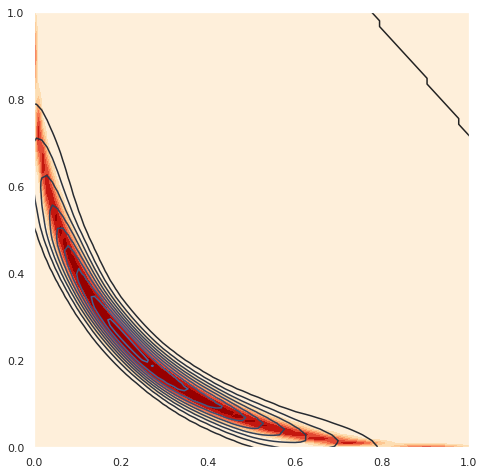

In [4]:
x1 = np.linspace(0, 1, 100)
x2 = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x1, x2)
moon_pe = lambda params: log_density(moon_model, (data,), {}, params)[0]
logP = vmap(vmap(moon_pe))({'x1': X1, 'x2': X2})
P = softmax(logP.reshape(-1)).reshape(logP.shape).clip(a_min=0.)

plt.figure(figsize=(8, 8))
plt.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(samples['x1'], samples['x2'])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal');

### questions

+ Can FlowHMC improve the tails?